In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/geiot

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torchvision import models,transforms
from PIL import Image
import cv2
import sys
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import os
import os.path as osp
from glob import glob
import pandas as pd
import PIL

In [2]:
test_data=pd.read_csv("TeamB/input/test/test_anno.csv", index_col=0).reset_index(drop=True)
train_data=pd.read_csv("TeamB/input/train/train_anno.csv", index_col=0).reset_index(drop=True)


#DataSetクラスの作成

In [3]:
class MyDataset(data.Dataset):
  def __init__(self,dataFrame,transforms):
    """
    初期化
    Param
    ===================
    dataFrame:pd.dataFrame
    画像とアノテーションが含まれているdataFrame
    transforms:
    前処理
    """
    self.dataframe=dataFrame
    self.transforms=transforms
    
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    while (True):
      r_label=self.dataframe.Label[idx]
      img=cv2.imread(self.dataframe.imagePath[idx]) #Image.open(self.img_path[idx])
      if img.shape[2]==1:
        idx=random.randint(0,len(self))
      else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        break
    if self.transforms:
      img=self.transforms(img)

    return img,r_label

# DataLoaderの実装

## 前処理

In [4]:
#TODO:Resizeのサイズ変更
traintransform=transforms.Compose([transforms.ToPILImage(),
                                   transforms.Resize((224,224)),
                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                   transforms.RandomPerspective(distortion_scale=0.2, p=0.3,interpolation=transforms.InterpolationMode.NEAREST),
                                   transforms.RandomAffine(degrees=[-10, 10], translate=(0.2, 0.3), scale=(0.5, 1),interpolation=transforms.InterpolationMode.NEAREST),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]
                                   )
testtransform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)),transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [5]:
train_dataset=MyDataset(train_data,transforms=traintransform)

In [6]:
test_dataset=MyDataset(test_data,transforms=testtransform)

## DataLoaderの作成

In [7]:
train_dataLoader=data.DataLoader(train_dataset,batch_size=10,shuffle=True)

E:\Anaconda\envs\AIProj\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

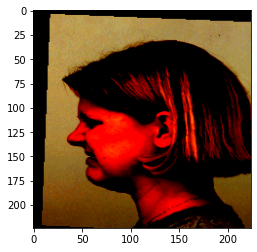

In [8]:
for datas,label in train_dataLoader:
  plt.imshow(datas[0].view(-1,224,224).detach().numpy().transpose(1, 2, 0))
  break

In [9]:
test_dataLoader=data.DataLoader(test_dataset,batch_size=10,shuffle=False)

# model ダウンロード

In [10]:
#学習済みモデルVGG16をロード

#VGG-16モデルのインスタンスを生成
net=models.resnet18(pretrained=False)
net.load_state_dict(torch.load('TeamB/modelParam/resnet18-f37072fd.pth'))


<All keys matched successfully>

In [11]:
#モデル追加
save_path='weight_fine_tuning_2way.pth'
#addmoduleだとforwardの定義がないためうまくいかない
net=nn.Sequential(net,nn.Linear(in_features=1000,out_features=2))
#if os.path.exists(save_path):
#  net.load_state_dict(torch.load(save_path))
net.train()
#net.add_module("last_fc",nn.Linear(1000,101,bias=False))

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

# 損失関数と最適化手法

In [13]:
criterion=nn.CrossEntropyLoss()

In [15]:
#このようにして配列に挿入した辞書函数使って、モデルパラメータごとにオプティマイザーのパラメーターを設定することができる
optimizer=optim.Adam(net.parameters())
#optimizer=optim.Adam(net.parameters(),lr=0.001)

In [16]:
def tarin_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
  #初期設定
  #GPUが使えるかを確認する
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print('使用でヴァイス:',device)
  #ネットワークをGPUへ
  net=net.to(device)
  #ネットワークがある程度固定(epochごとにネットワーク構造や損失関数が変わったりしない)の場合に高速化させる
  torch.backends.cudnn.benchmark=True
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1,num_epochs))
    print('__________')
    for phase in ['train','test']:
      if phase=='train':
        net.train()
      else:
        net.eval()
      epoch_loss=0.0
      epoch_corrects=0
      for inputs,labels in tqdm(data_loaders_dict[phase]):
        #入力をGPUへ
        inputs=inputs.to(device)
        labels=labels.to(device)
        #optimizerの初期化
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs=net(inputs)
          #print("output",outputs.shape)
          #print("labels",torch.max(labels,1)[1])
          loss=criterion(outputs,labels)
          _,preds=torch.max(outputs,1)
          if phase=='train':
            loss.backward()
            optimizer.step()
          #tensor.item()はTensor内部の数値をPythonの数字で出力.戻り値はintやfloat
          epoch_loss+=loss.item()*inputs.size(0)
          #Tensor.dataはTensorのコピーを作成する。戻り値もTensor
          epoch_corrects+=torch.sum(preds==labels.data)
      epoch_loss=epoch_loss/len(data_loaders_dict[phase].dataset)
      epoch_acc=epoch_corrects.double()/len(data_loaders_dict[phase].dataset)
      net=net.to("cpu")
      torch.save(net.state_dict(),save_path)
      net=net.to(device)
      print('{} Loss: {:4f} Acc: {:4f}'.format(phase,epoch_loss,epoch_acc))
      print("output",outputs.shape)

In [17]:
data_loaders_dict={"train":train_dataLoader,"test":test_dataLoader}

In [18]:
num=50
tarin_model(net,data_loaders_dict,criterion,optimizer,num_epochs=num)

使用でヴァイス: cuda
Epoch 1/50
__________


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]E:\Anaconda\envs\AIProj\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:15<00:00,  5.19it/s]


train Loss: 1.213762 Acc: 0.593894
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


test Loss: 0.431242 Acc: 0.851000
output torch.Size([10, 7])
Epoch 2/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.63it/s]


train Loss: 0.701413 Acc: 0.751924
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


test Loss: 0.427661 Acc: 0.860000
output torch.Size([10, 7])
Epoch 3/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.57it/s]


train Loss: 0.570435 Acc: 0.798102
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.38it/s]


test Loss: 0.468819 Acc: 0.855000
output torch.Size([10, 7])
Epoch 4/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.62it/s]


train Loss: 0.513942 Acc: 0.816573
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.26it/s]


test Loss: 0.547069 Acc: 0.833000
output torch.Size([10, 7])
Epoch 5/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.60it/s]


train Loss: 0.494112 Acc: 0.831965
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.40it/s]


test Loss: 0.346288 Acc: 0.885000
output torch.Size([10, 7])
Epoch 6/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:11<00:00,  5.47it/s]


train Loss: 0.424779 Acc: 0.853002
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.38it/s]


test Loss: 0.380814 Acc: 0.877000
output torch.Size([10, 7])
Epoch 7/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.63it/s]


train Loss: 0.406928 Acc: 0.859672
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


test Loss: 0.386789 Acc: 0.872000
output torch.Size([10, 7])
Epoch 8/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:10<00:00,  5.52it/s]


train Loss: 0.386172 Acc: 0.864546
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.40it/s]


test Loss: 0.362603 Acc: 0.885000
output torch.Size([10, 7])
Epoch 9/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.60it/s]


train Loss: 0.352756 Acc: 0.874808
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


test Loss: 0.375315 Acc: 0.878000
output torch.Size([10, 7])
Epoch 10/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.62it/s]


train Loss: 0.334685 Acc: 0.884300
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


test Loss: 0.383563 Acc: 0.872000
output torch.Size([10, 7])
Epoch 11/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.62it/s]


train Loss: 0.341968 Acc: 0.880195
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


test Loss: 0.634405 Acc: 0.838000
output torch.Size([10, 7])
Epoch 12/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.64it/s]


train Loss: 0.320103 Acc: 0.884043
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.44it/s]


test Loss: 0.465420 Acc: 0.864000
output torch.Size([10, 7])
Epoch 13/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.65it/s]


train Loss: 0.296444 Acc: 0.899436
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


test Loss: 0.352923 Acc: 0.898000
output torch.Size([10, 7])
Epoch 14/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.61it/s]


train Loss: 0.314063 Acc: 0.893535
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.38it/s]


test Loss: 0.425418 Acc: 0.861000
output torch.Size([10, 7])
Epoch 15/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.58it/s]


train Loss: 0.271081 Acc: 0.905336
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


test Loss: 0.431490 Acc: 0.865000
output torch.Size([10, 7])
Epoch 16/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.73it/s]


train Loss: 0.267486 Acc: 0.904823
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.46it/s]


test Loss: 0.339574 Acc: 0.891000
output torch.Size([10, 7])
Epoch 17/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.74it/s]


train Loss: 0.286180 Acc: 0.900975
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


test Loss: 0.526418 Acc: 0.842000
output torch.Size([10, 7])
Epoch 18/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.270938 Acc: 0.902258
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.566270 Acc: 0.818000
output torch.Size([10, 7])
Epoch 19/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.75it/s]


train Loss: 0.251702 Acc: 0.908415
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


test Loss: 0.402983 Acc: 0.887000
output torch.Size([10, 7])
Epoch 20/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.260465 Acc: 0.916624
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


test Loss: 0.341875 Acc: 0.887000
output torch.Size([10, 7])
Epoch 21/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.73it/s]


train Loss: 0.269873 Acc: 0.902001
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.466779 Acc: 0.857000
output torch.Size([10, 7])
Epoch 22/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.240475 Acc: 0.915598
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


test Loss: 0.545700 Acc: 0.845000
output torch.Size([10, 7])
Epoch 23/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.248986 Acc: 0.910210
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.343801 Acc: 0.907000
output torch.Size([10, 7])
Epoch 24/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.75it/s]


train Loss: 0.241355 Acc: 0.916111
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.382170 Acc: 0.869000
output torch.Size([10, 7])
Epoch 25/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.236916 Acc: 0.913289
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


test Loss: 0.426123 Acc: 0.875000
output torch.Size([10, 7])
Epoch 26/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.244456 Acc: 0.919446
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


test Loss: 0.347825 Acc: 0.885000
output torch.Size([10, 7])
Epoch 27/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.214871 Acc: 0.928168
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


test Loss: 0.409725 Acc: 0.878000
output torch.Size([10, 7])
Epoch 28/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.74it/s]


train Loss: 0.215739 Acc: 0.924064
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


test Loss: 0.367673 Acc: 0.890000
output torch.Size([10, 7])
Epoch 29/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.220906 Acc: 0.919189
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.336423 Acc: 0.902000
output torch.Size([10, 7])
Epoch 30/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.209006 Acc: 0.927399
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


test Loss: 0.297438 Acc: 0.907000
output torch.Size([10, 7])
Epoch 31/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.75it/s]


train Loss: 0.191441 Acc: 0.937660
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.388660 Acc: 0.872000
output torch.Size([10, 7])
Epoch 32/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.202685 Acc: 0.932016
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.316764 Acc: 0.906000
output torch.Size([10, 7])
Epoch 33/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.189824 Acc: 0.938430
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


test Loss: 0.302128 Acc: 0.899000
output torch.Size([10, 7])
Epoch 34/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.187228 Acc: 0.937660
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


test Loss: 0.348367 Acc: 0.897000
output torch.Size([10, 7])
Epoch 35/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.198955 Acc: 0.928681
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.291138 Acc: 0.903000
output torch.Size([10, 7])
Epoch 36/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.73it/s]


train Loss: 0.196439 Acc: 0.931247
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.401052 Acc: 0.882000
output torch.Size([10, 7])
Epoch 37/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.196067 Acc: 0.930221
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


test Loss: 0.314980 Acc: 0.905000
output torch.Size([10, 7])
Epoch 38/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.199544 Acc: 0.932530
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


test Loss: 0.270509 Acc: 0.906000
output torch.Size([10, 7])
Epoch 39/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.71it/s]


train Loss: 0.171819 Acc: 0.938430
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


test Loss: 0.281146 Acc: 0.902000
output torch.Size([10, 7])
Epoch 40/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.168223 Acc: 0.942791
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.302317 Acc: 0.902000
output torch.Size([10, 7])
Epoch 41/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.78it/s]


train Loss: 0.184286 Acc: 0.937404
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


test Loss: 0.312273 Acc: 0.902000
output torch.Size([10, 7])
Epoch 42/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.78it/s]


train Loss: 0.182412 Acc: 0.936634
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


test Loss: 0.257001 Acc: 0.918000
output torch.Size([10, 7])
Epoch 43/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.76it/s]


train Loss: 0.178337 Acc: 0.933812
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


test Loss: 0.267471 Acc: 0.909000
output torch.Size([10, 7])
Epoch 44/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.79it/s]


train Loss: 0.186911 Acc: 0.933556
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


test Loss: 0.286243 Acc: 0.908000
output torch.Size([10, 7])
Epoch 45/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.79it/s]


train Loss: 0.148916 Acc: 0.950231
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


test Loss: 0.385957 Acc: 0.879000
output torch.Size([10, 7])
Epoch 46/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.77it/s]


train Loss: 0.174220 Acc: 0.939456
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


test Loss: 0.346964 Acc: 0.886000
output torch.Size([10, 7])
Epoch 47/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:08<00:00,  5.73it/s]


train Loss: 0.149253 Acc: 0.944074
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


test Loss: 0.345807 Acc: 0.890000
output torch.Size([10, 7])
Epoch 48/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.80it/s]


train Loss: 0.140491 Acc: 0.949974
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


test Loss: 0.266866 Acc: 0.922000
output torch.Size([10, 7])
Epoch 49/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.79it/s]


train Loss: 0.158074 Acc: 0.942278
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


test Loss: 0.333028 Acc: 0.889000
output torch.Size([10, 7])
Epoch 50/50
__________


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:07<00:00,  5.80it/s]


train Loss: 0.148885 Acc: 0.945613
output torch.Size([8, 7])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.46it/s]


test Loss: 0.375973 Acc: 0.892000
output torch.Size([10, 7])


In [19]:
dat

NameError: ignored